# Attention is all you need!

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation.

While this architecture is somewhat outdated it is still a very useful project to work through to get a deeper understanding of attention mechanisms (before going on to Transformers).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "¿todavia estan en casa?", and return the English translation: "are you still at home?"

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

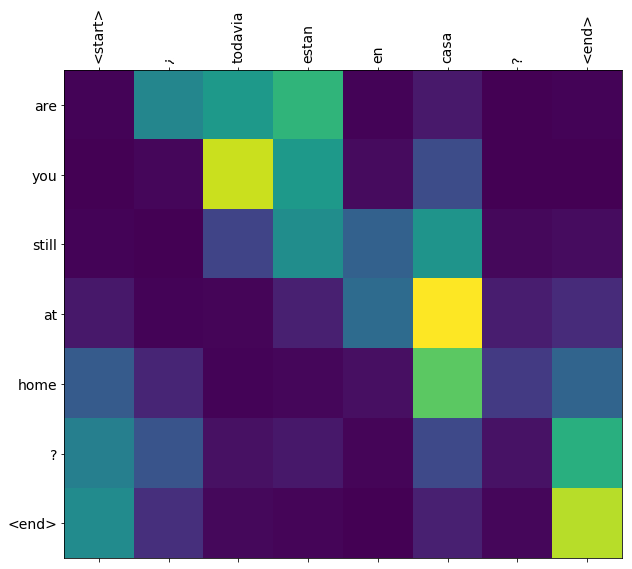

In [1]:
! pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 7.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.2 kB/s 
     |████████████████████████████████| 1.6 MB 40.7 MB/s 
     |████████████████████████████████| 5.8 MB 26.8 MB/s 
     |████████████████████████████████| 438 kB 57.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#### Shape Checker

In low-level API Codes, it's easy to get shapes wrong. Following class implements the check to ensure tensors are in proper shape as expected by the model

In [3]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## EDA and Data Preparation

We'll use a language dataset provided by http://www.manythings.org/anki/ This dataset contains language translation pairs in the format:

> May I borrow this book? ¿Puedo tomar prestado este libro?



### Download the dataset

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

2638744/2638744 [==============================] - 0s 0us/step


After downloading the dataset, here are the steps we'll take to prepare the data:

* Add a start and end token to each sentence.
* Clean the sentences by removing special characters.
* Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
* Pad each sentence to a maximum length.

In [5]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

targ, inp = load_data(path_to_file)
print("Example Input Sequence : ", inp[-1])
print("Example Target Sequence : ", targ[-1])

Example Input Sequence :  Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
Example Target Sequence :  If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a TF Dataset

From these arrays of strings you can create a tf.data.Dataset of strings that shuffles and batches them efficiently:

From the [Doc](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - 

> Randomly shuffles the elements of this dataset.\
  This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.\
  For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [6]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Sol\xc3\xadamos ser amigos cercanos.'
 b'Tom ha vivido en Boston durante m\xc3\xa1s de un a\xc3\xb1o.'
 b'Ellos me ense\xc3\xb1aron a maldecir.'
 b'Ens\xc3\xa9\xc3\xb1ame tu nueva direcci\xc3\xb3n.'
 b'Por favor, arreglalo.'], shape=(5,), dtype=string)

tf.Tensor(
[b'We used to be close friends.'
 b'Tom has lived in Boston for more than a year.'
 b'They just taught me to swear.' b'Let me know your new address.'
 b'Please fix it.'], shape=(5,), dtype=string)


### Text preprocessing

`Standardization`

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The tensorflow_text package contains a unicode normalize operation:

In [7]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [8]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


### Text Vectorization
This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [9]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [10]:
# We need to adapt the Vectorization layer to the input and target sequences

input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [11]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [12]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2, 3078,   81,  187, 4867,    4,    3,    0,    0,    0],
       [   2,   10,   61, 1382,   14,  137,  241,   35,    6,   16],
       [   2,   78,   18,    1,    8,    1,    4,    3,    0,    0]])>

The get_vocabulary method can be used to convert token IDs back to text:

In [13]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] soliamos ser amigos cercanos . [END]             '

Text(0.5, 1.0, 'Mask')

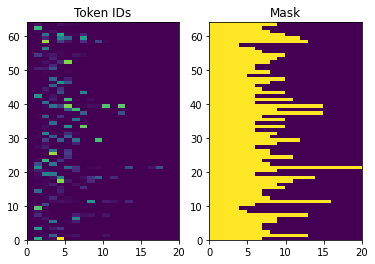

In [14]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. 

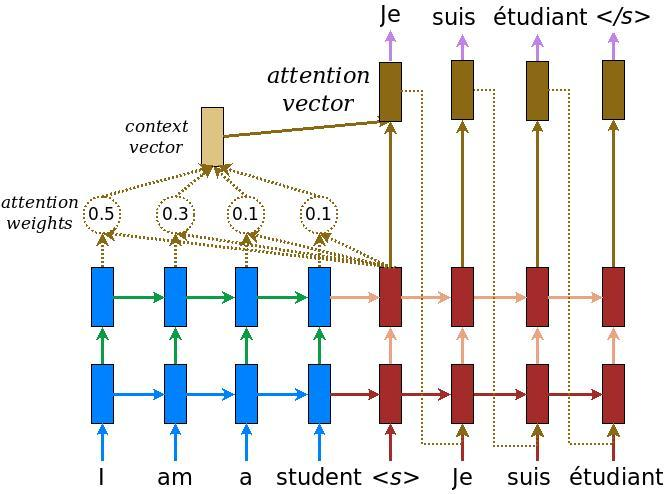


In [15]:
embedding_dim = 256
units = 1024

### The encoder
Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from input_text_processor).
2. Looks up an embedding vector for each token (Using a layers.Embedding).
3. Processes the embeddings into a new sequence (Using a layers.GRU).
4. Returns:\
      * The processed sequence. This will be passed to the attention head.
      * The internal state. This will be used to initialize the decoder

In [16]:
# Inherit from TF Keras Layers, so that the encoder class has all the methods of the TF Layers
class Encoder(tf.keras.layers.Layer):
  
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    # initialize the super class
    super(Encoder, self).__init__()
    # Define Encoder units
    self.enc_units = enc_units
    # Define the vocab size for the encoder
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors - initialize using vocab size and embedding dims
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    # Encoder units - enc_units is the parameter 'units' for the Gated RNN and defines the dimension of the outer space
    # Return Sequence - Whether to return the last output in the output sequence, or the full sequence.
    # Recurrent Initializer - Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state.
    # The goal of Xavier Initialization (or Glorot Uniform) is to initialize the weights such that
    # the variance of the activations are the same across every layer.
    # This constant variance helps prevent the gradient from exploding or vanishing.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def call(self, tokens, state=None):
    # Initialize Shape Checker class and test on input tokens
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Let's look the output from the Encoder

In [17]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [18]:
# For a single output
example_input_batch[0], example_tokens[0], example_enc_output[0], example_enc_state[0]

(<tf.Tensor: shape=(), dtype=string, numpy=b'Sol\xc3\xadamos ser amigos cercanos.'>,
 <tf.Tensor: shape=(20,), dtype=int64, numpy=
 array([   2, 3078,   81,  187, 4867,    4,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])>,
 <tf.Tensor: shape=(20, 1024), dtype=float32, numpy=
 array([[-5.76013047e-03,  2.52633402e-03, -5.87595906e-03, ...,
         -6.30026823e-03,  5.76025108e-03, -1.32542197e-02],
        [-2.42965925e-03, -1.05639203e-02, -8.29440728e-03, ...,
          6.33679610e-03, -3.10682738e-03, -6.51145307e-03],
        [-9.35701374e-03, -2.98639340e-03,  5.58005273e-03, ...,
         -2.26451550e-04, -6.70949230e-05, -1.29695702e-03],
        ...,
        [-1.53097585e-02,  6.40573539e-03, -1.36233475e-02, ...,
         -3.09810019e-03, -3.43256374e-03,  1.20321801e-03],
        [-1.53351426e-02,  6.40272349e-03, -1.36732357e-02, ...,
         -3.09940241e-03, -3.45171569e-03,  1.17758627e-03],
        [-1.53521709e-02,  6.39978

The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head
The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a layers.GlobalAveragePoling1D but the attention layer performs a weighted average.

Let's look at how this works:

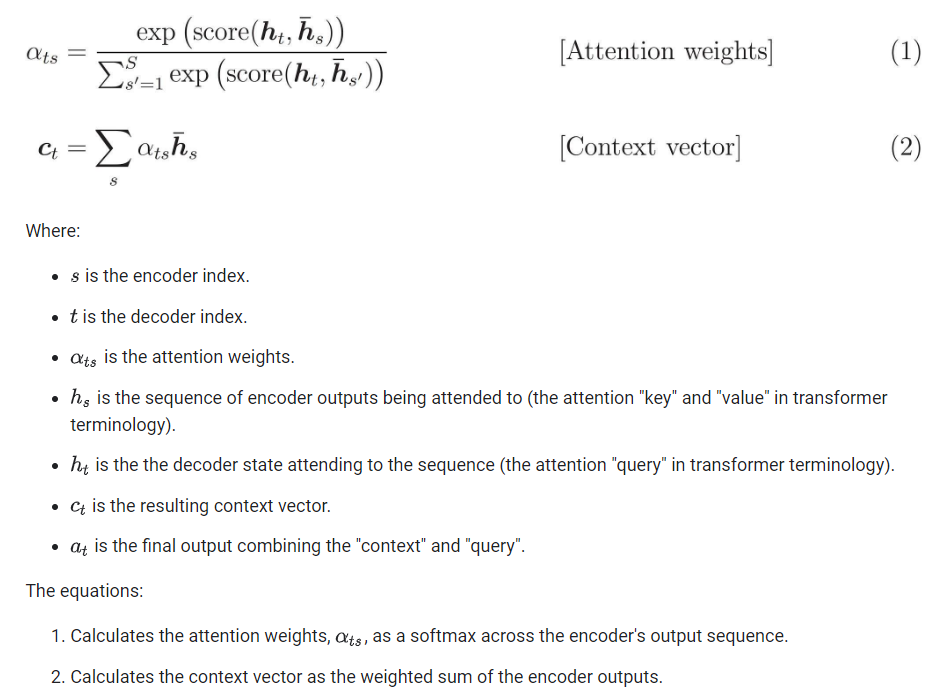

Last is the `score` function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

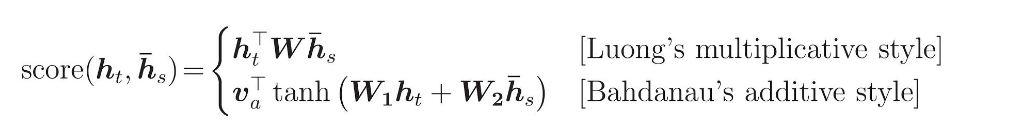

This tutorial uses Bahdanau's additive attention. TensorFlow includes implementations of both as layers.Attention and layers.AdditiveAttention. The class below handles the weight matrices in a pair of layers.Dense layers, and calls the builtin implementation.

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    # Define the attention type - Additive attention layer, a.k.a. Bahdanau-style attention.
    # Inputs are query tensor of shape [batch_size, Tq, dim], 
    #            value tensor of shape [batch_size, Tv, dim] and
    #            key tensor of shape [batch_size, Tv, dim].
    # The calculation follows the steps:
    # Reshape query and key into shapes [batch_size, Tq, 1, dim] and [batch_size, 1, Tv, dim] respectively.
    # Calculate scores with shape [batch_size, Tq, Tv] as a non-linear sum: scores = tf.reduce_sum(tf.tanh(query + key), axis=-1)
    # Use scores to calculate a distribution with shape [batch_size, Tq, Tv]: distribution = tf.nn.softmax(scores).
    # Use distribution to create a linear combination of value with shape [batch_size, Tq, dim]: return tf.matmul(distribution, value).
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht` - Query Vector passed through Dense Layer
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs` - Value vector passed through Dense Layer
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    # Initialize Query Mask
    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    # Value Mask is initialized from the input
    value_mask = mask

    # Get Context Vector and Attention weights from the Additive Attention
    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### The Decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

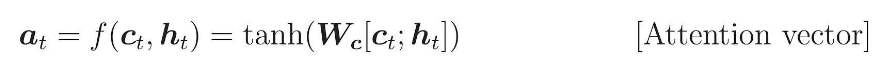

In [35]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    # Define Decoder Units
    self.dec_units = dec_units
    # Define Output Vocab Size
    self.output_vocab_size = output_vocab_size
    # Define Embedding Dimensions
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

# The call method for this layer takes and returns multiple tensors. Organize those into simple container classes:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

def call(self,
        inputs: DecoderInput,
        state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state
Decoder.call = call

The decoder takes 4 inputs.

* new_tokens - The last token generated. Initialize the decoder with the "[START]" token.
* enc_output - Generated by the Encoder.
* mask - A boolean tensor indicating where tokens != 0
* state - The previous state output from the decoder (the internal state of the decoder's RNN). Pass None to zero-initialize it. The original paper initializes it from the encoder's final RNN state.

In [25]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

# Run the decoder
dec_result, dec_state = decoder(
    inputs = decoder.DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [30]:
# Let's test the decoder on a sample input

# Sample a token according to the logits:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
print("Sampled Token Shape : ", sampled_token.shape)
# Decode the token as the first word of the output:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]
print("First Word Shape : ", first_word.shape)

Sampled Token Shape :  (64, 1)
First Word Shape :  (64, 1)


## Training

Now that you have all the model components, it's time to start training the model. You'll need:

A loss function and optimizer to perform the optimization.\
A training step function defining how to update the model for each input/target batch.\
A training loop to drive the training and save checkpoints.

### Define the loss function

In [32]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Training Step

Start with a model class, the training process will be implemented as the train_step method on this model.

Here the train_step method is a wrapper around the _train_step implementation which will come later. This wrapper includes a switch to turn on and off tf.function compilation, to make debugging easier.

In [31]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the Model.train_step method is as follows:

1. Receive a batch of input_text, target_text from the tf.data.Dataset.
2. Convert those raw text inputs to token-embeddings and masks.
3. Run the encoder on the input_tokens to get the encoder_output and encoder_state.
4. Initialize the decoder state and loss.
5. Loop over the target_tokens:\
    a. Run the decoder one step at a time.\
    b. Calculate the loss for each step.\
    c. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.


The _preprocess method, added below, implements steps #1 and #2:

In [33]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

TrainTranslator._preprocess = _preprocess

The _train_step method, added below, handles the remaining steps except for actually running the decoder:

In [34]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

TrainTranslator._train_step = _train_step

The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).

In [41]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

TrainTranslator._loop_step = _loop_step

### Test the training step

Build a TrainTranslator, and configure it for training using the Model.compile method:

In [37]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [38]:
# Test out the train_step. For a text model like this the loss should start near:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [42]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5724483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5429077>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4878683>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.326423>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6850433>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.98577>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.51122>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2806096>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0982604>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.963351>}

CPU times: user 2min 35s, sys: 4.2 s, total: 2min 39s
Wall time: 1min 35s
